<a href="https://colab.research.google.com/github/CraigPhayer/CS4287-CNN/blob/main/CS4287-Assign2-21340633-21332967.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Craig Phayer - 21340633
# Adam Collins - 21332967

# The code executes to the end without an error.

# Sources Cited:
#

In [10]:
# Imports
import kagglehub
from pathlib import Path
from PIL import Image
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
from tensorflow.python.eager.profiler_client import monitor
from sklearn.preprocessing import LabelEncoder

In [2]:
# Dataset Link: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
# All images are 224 x 224 x 3 in jpg format and are cropped to ensure only the image of a single card is present, and the card occupies over 50% of the pixels in the image.

# Fetches the dataset from Kaggle and downloads it onto the local machine.
dataset_path = Path(kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification"))

# Prints the location of the dataset, confirming the correct download path.
print("Path to dataset files:", dataset_path)

# Prints all items within the dataset path, providing an overview of the datasets structure.
print("Contents of dataset_path:", list(dataset_path.iterdir()))

100%|██████████| 385M/385M [00:05<00:00, 69.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2
Contents of dataset_path: [PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid'), PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/14card types-14-(200 X 200)-94.61.h5'), PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'), PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/cards.csv'), PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'), PosixPath('/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/53cards-53-(200 X 200)-100.00.h5')]


Total images loaded from 'train' folder: 7624
Sample labels: ['ten of clubs', 'ten of clubs', 'ten of clubs', 'ten of clubs', 'ten of clubs']

Class to Label Mapping:
0: ace of clubs
1: ace of diamonds
2: ace of hearts
3: ace of spades
4: eight of clubs
5: eight of diamonds
6: eight of hearts
7: eight of spades
8: five of clubs
9: five of diamonds
10: five of hearts
11: five of spades
12: four of clubs
13: four of diamonds
14: four of hearts
15: four of spades
16: jack of clubs
17: jack of diamonds
18: jack of hearts
19: jack of spades
20: joker
21: king of clubs
22: king of diamonds
23: king of hearts
24: king of spades
25: nine of clubs
26: nine of diamonds
27: nine of hearts
28: nine of spades
29: queen of clubs
30: queen of diamonds
31: queen of hearts
32: queen of spades
33: seven of clubs
34: seven of diamonds
35: seven of hearts
36: seven of spades
37: six of clubs
38: six of diamonds
39: six of hearts
40: six of spades
41: ten of clubs
42: ten of diamonds
43: ten of hearts
44: 

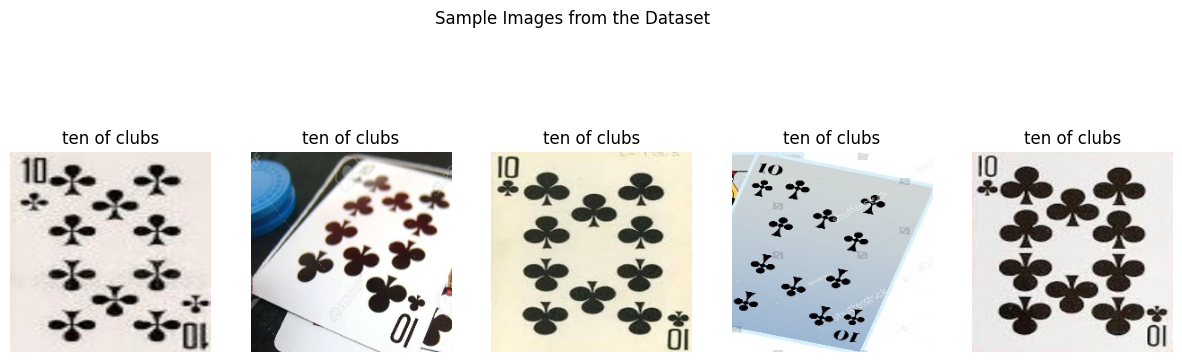

In [11]:
# Organising and checking the dataset.
# Prints sample images to confirm loading and labels.

# Empty lists used to store the file paths of images and their labels.
image_paths = []
labels = []

# Only looping through the 'train' directory to gather images and labels.
# We are using the train directory to both train and test our CNN.
train_path = dataset_path / 'train'
for class_folder in train_path.iterdir():
    if class_folder.is_dir():
        # Assigns the folder name as the label.
        label = class_folder.name
        for img_file in class_folder.glob("*.jpg"):
            image_paths.append(img_file)
            labels.append(label)


# Prints total number of images loaded & displays first 5 labels.
print(f"Total images loaded from 'train' folder: {len(image_paths)}")
print("Sample labels:", labels[:5])

# Label Encoding
# Converting class labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Printing the class-to-label mapping
print("\nClass to Label Mapping:")
for class_name, label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{label}: {class_name}")

# Printing a sample of our encoded labels
print("\nSample Encoded Labels (First 5):", encoded_labels[:5])

# Collecting the names of all folders within the dataset path that represent the different classes, and printing the list of class names.
class_names = [folder.name for folder in dataset_path.iterdir() if folder.is_dir()]

# Printing unique classes in the dataset
print("\nDetected Classes in the Dataset:")
print(class_names)

# Visualises a sample of the images.
def display_sample_images(num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Sample Images from the Dataset")

    for i in range(num_samples):
        image_path = image_paths[i]
        label = labels[i]

        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis("off")

    plt.show()

display_sample_images(5)

Splitting the dataset into training and testing.

In [4]:
from sklearn.model_selection import train_test_split

# Using test_train_split from sklearn to split dataset into training and testing.
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

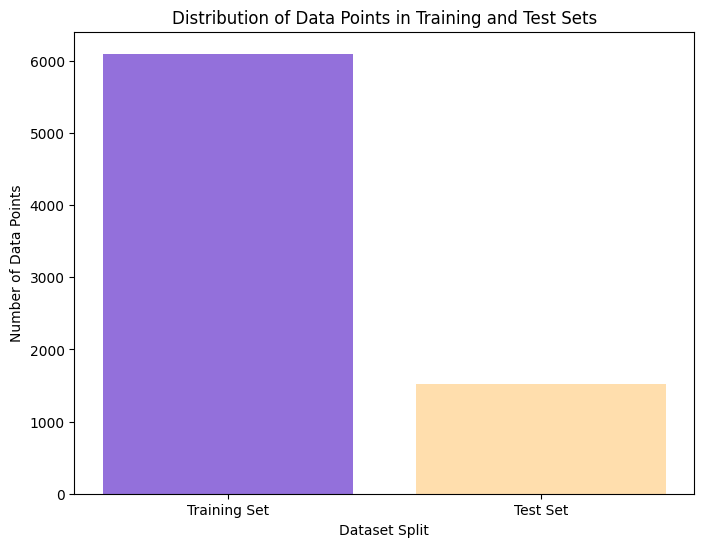

In [5]:
# Visualising our training and testing sets.

# Number of data points.
training_data_count = len(y_train)
testing_data_count = len(y_test)

# Define categories and their counts.
data_categories = ['Training Set', 'Test Set']
data_counts = [training_data_count, testing_data_count]

# Print the barchart.
plt.figure(figsize=(8, 6))
plt.bar(data_categories, data_counts, color=['mediumpurple', 'navajowhite'])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points in Training and Test Sets')
plt.show()

### InceptionV3

In [10]:
from tensorflow.keras import regularizers

def inceptionV3_model(optimizer='Adam', learning_rate=0.0005):

    # Model preparation
    base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    # Init freeze all layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True


    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(2048, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(2048, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(53, activation="softmax")(x)

    if optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type. Choose 'RMSprop', 'Adam', or 'SGD'.")

    model = Model(base_model.input, output)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

inceptionV3_model().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 30,320,469 (115.66 MB)

 Trainable params: 13,665,525 (52.13 MB)

 Non-trainable params: 16,654,944 (63.53 MB)

### ResNet-34

In [11]:
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers

def resnet34_model(optimizer='Adam', learning_rate=0.0005):
    base_model = hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_34/classification/1", trainable=True)

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(2048, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(2048, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(53, activation="softmax")(x)

    if optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type. Choose 'RMSprop', 'Adam', or 'SGD'.")

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

resnet34_model().summary()

### K-Fold cross validation

In [7]:
def k_fold(build_fn, n_splits=5, batch_size=32, epochs=20, verbose=1):
    # Convert to DataFrame for k-folds
    df = pd.DataFrame({"filename": image_paths, "class": labels})

    # Augment the images in our dataset
    # - rescale the images into normalized values [0,1]
    # - image rotation so during training the model can better generalize
    # - shift images vertically and horizontally by 20% so the model becomes better at dealing with invariants in images
    # - zoom in/out for better recognition of objects at different scales
    data_gen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=50,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    histories = []

    for train_idx, val_idx in kfold.split(df["filename"], df["class"]):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        train_df['filename'] = train_df['filename'].astype(str)
        val_df['filename'] = val_df['filename'].astype(str)

        train_generator = data_gen.flow_from_dataframe(
            train_df,
            x_col="filename",
            y_col="class",
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=batch_size
        )

        val_generator = data_gen.flow_from_dataframe(
            val_df,
            x_col="filename",
            y_col="class",
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=batch_size
        )

        model = build_fn()
        # Monitor val_loss, if it stops improving or increases the scheduler reduces the learning rate by the set factor
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3)
        #patience = the no. of epochs the scheduler will wait before triggering

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weights = dict(enumerate(class_weights))

        print(f"Training on fold {fold_no}...")
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=[lr_scheduler, early_stopping],
            class_weight=class_weights,
            verbose=verbose
        )
        fold_no += 1

        histories.append(history)
    return histories

iV3 = k_fold(inceptionV3_model)

Found 6099 validated image filenames belonging to 53 classes.
Found 1525 validated image filenames belonging to 53 classes.


<ipython-input-7-ef7027d62e60>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['filename'] = train_df['filename'].astype(str)
<ipython-input-7-ef7027d62e60>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['filename'] = val_df['filename'].astype(str)


Training on fold 1...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - acc: 0.0908 - loss: 4.8371

KeyboardInterrupt: 